In [65]:
# conda install -c dglteam dgl  

In [66]:
import dgl

In [67]:
import dgl
import numpy as np

def build_karate_club_graph():
    # All 78 edges are stored in two numpy arrays. One for source endpoints while the other for destination endpoints.
    src_endpoints = np.array([1, 2, 2, 3, 3, 3, 4, 5, 6, 6, 6, 7, 7, 7, 7, 8, 8, 9, 10, 10,
        10, 11, 12, 12, 13, 13, 13, 13, 16, 16, 17, 17, 19, 19, 21, 21,
        25, 25, 27, 27, 27, 28, 29, 29, 30, 30, 31, 31, 31, 31, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
    dst_endpoints = np.array([0, 0, 1, 0, 1, 2, 0, 0, 0, 4, 5, 0, 1, 2, 3, 0, 2, 2, 0, 4,
        5, 0, 0, 3, 0, 1, 2, 3, 5, 6, 0, 1, 0, 1, 0, 1, 23, 24, 2, 23,
        24, 2, 23, 26, 1, 8, 0, 24, 25, 28, 2, 8, 14, 15, 18, 20, 22, 23,
        29, 30, 31, 8, 9, 13, 14, 15, 18, 19, 20, 22, 23, 26, 27, 28, 29, 30,
        31, 32])
    # Edges are directional in DGL; Make them bi-directional.
    u = np.concatenate([src_endpoints, dst_endpoints])
    v = np.concatenate([dst_endpoints, src_endpoints])
    # Construct a DGLGraph
    return dgl.DGLGraph((u, v))

In [68]:
club_graph = build_karate_club_graph()
print('We have %d nodes.' % club_graph.number_of_nodes())
print('We have %d edges.' % club_graph.number_of_edges())
club_graph

We have 34 nodes.
We have 156 edges.


Graph(num_nodes=34, num_edges=156,
      ndata_schemes={}
      edata_schemes={})

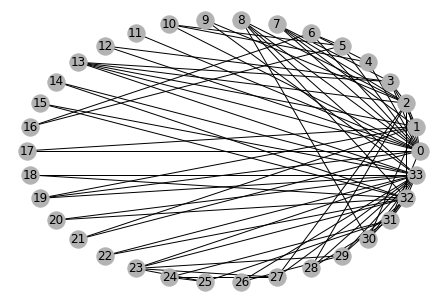

In [69]:
import networkx as nx
# Since the actual graph is undirected, converting it for visualization purpose.
undirected_club_graph = club_graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(undirected_club_graph)
# nx.draw(undirected_club_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])

nx.draw_circular(undirected_club_graph, node_color=[[.7, .7, .7]], with_labels=True)

In [70]:
# Adding features for all nodes at once, using a feature tensor that batches node features along the first dimension. Adding the learnable embeddings for all nodes:
import torch
import torch.nn as nn
import torch.nn.functional as F

embed = nn.Embedding(34, 10)  # adding 10 features to each of the 34 nodes
club_graph.ndata['feat'] = embed.weight

In [71]:
# Input features of node 0, 17 and 33
print(club_graph.ndata['feat'][[0, 17, 33]])

tensor([[ 0.5949,  1.5235, -0.3938, -0.4717, -0.4854,  0.4439,  0.1275, -0.9532,
         -0.7806, -1.1034],
        [ 0.7096,  1.6451, -0.6630, -0.9191,  1.7170,  0.0754,  0.0245, -0.6104,
         -1.4908, -0.3550],
        [ 1.6175,  1.3453, -0.2350, -0.9812,  0.3754,  0.3731, -1.2951, -0.8305,
         -1.7023,  0.4446]], grad_fn=<IndexBackward>)


In [72]:
from dgl.nn.pytorch import GraphConv



In [73]:
# The first layer transforms input features of size of 5 to a hidden size of 5. 
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.

class GCN_layer(nn.Module):
    def __init__(self, input_features, hidden_size, class_number):
        super(GCN_layer, self).__init__()
        self.conv1 = GraphConv(input_features, hidden_size)
        self.conv2 = GraphConv(hidden_size, class_number)

    def forward(self, g, inputs):
        h = self.conv1(g, inputs)
        h = torch.relu(h)
        h = self.conv2(g, h)
        return h

network_model = GCN_layer(input_features=10, hidden_size=7, class_number=2)
print(network_model)
# network_model.summary()

GCN_layer(
  (conv1): GraphConv(in=10, out=7, normalization=both, activation=None)
  (conv2): GraphConv(in=7, out=2, normalization=both, activation=None)
)


In [74]:
inputs = embed.weight
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1])  # their labels are different

In [75]:
import itertools

optimizer = torch.optim.Adam(itertools.chain(network_model.parameters(), embed.parameters()), lr=0.01)
all_logits = []
for epoch in range(100):
    logits = network_model(club_graph, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6889
Epoch 1 | Loss: 0.6240
Epoch 2 | Loss: 0.5681
Epoch 3 | Loss: 0.5176
Epoch 4 | Loss: 0.4707
Epoch 5 | Loss: 0.4263
Epoch 6 | Loss: 0.3811
Epoch 7 | Loss: 0.3378
Epoch 8 | Loss: 0.2973
Epoch 9 | Loss: 0.2597
Epoch 10 | Loss: 0.2250
Epoch 11 | Loss: 0.1941
Epoch 12 | Loss: 0.1658
Epoch 13 | Loss: 0.1402
Epoch 14 | Loss: 0.1174
Epoch 15 | Loss: 0.0974
Epoch 16 | Loss: 0.0804
Epoch 17 | Loss: 0.0661
Epoch 18 | Loss: 0.0543
Epoch 19 | Loss: 0.0444
Epoch 20 | Loss: 0.0364
Epoch 21 | Loss: 0.0297
Epoch 22 | Loss: 0.0245
Epoch 23 | Loss: 0.0202
Epoch 24 | Loss: 0.0168
Epoch 25 | Loss: 0.0140
Epoch 26 | Loss: 0.0118
Epoch 27 | Loss: 0.0100
Epoch 28 | Loss: 0.0086
Epoch 29 | Loss: 0.0074
Epoch 30 | Loss: 0.0064
Epoch 31 | Loss: 0.0056
Epoch 32 | Loss: 0.0049
Epoch 33 | Loss: 0.0043
Epoch 34 | Loss: 0.0038
Epoch 35 | Loss: 0.0034
Epoch 36 | Loss: 0.0031
Epoch 37 | Loss: 0.0028
Epoch 38 | Loss: 0.0026
Epoch 39 | Loss: 0.0023
Epoch 40 | Loss: 0.0022
Epoch 41 | Loss: 0.0020
Ep

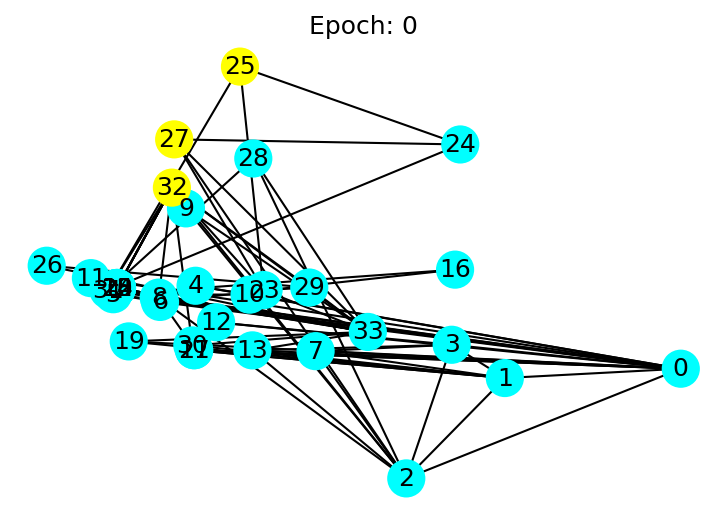

In [76]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    
    cls1color = '#FFFF00'
    cls2color = '#00FFFF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(undirected_club_graph.to_undirected(), pos, node_color=colors, with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
# plt.savefig('epoch50.png')
plt.show()

In [77]:
# ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

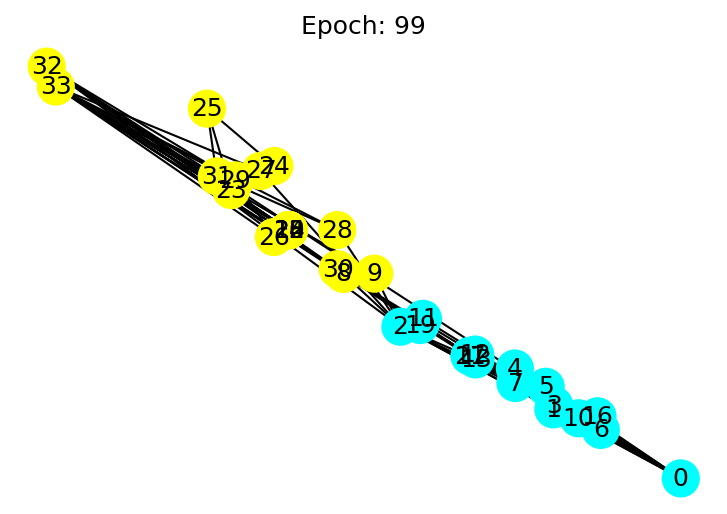

In [82]:
fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(99)  # draw the prediction of the first epoch
plt.savefig('epoch99.png')
plt.show()